### 2D Lidar Representation Using Image data with SAM, CLIP AND BLIP-2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [26]:
#!gdown --id 1VQ3veec4RgZgi-bmEi_Hd-viQmgzmd2B
#!gdown --id 1tAIjQZe92sSqBvLTS-TZykJC_kZkgcXk

# Para descomprimir las imágenes
#!unzip images.zip 

# Para descomprimir los datos LiDAR
#!unzip lidar.zip 


In [6]:
## get image path
PATH_IMAGES = "images"
df_images = pd.DataFrame(columns=["id","img_front"])
for i in range(0, 150):
    df_images = pd.concat([df_images, pd.DataFrame({"id": [i],
                                                    "img_front": [f"{PATH_IMAGES}/front/image_{i}_.png"],
                                                    })
                           ], ignore_index=True)
df_images.head()

,id,img_front
0,0,images/front/image_0_.png
1,1,images/front/image_1_.png
2,2,images/front/image_2_.png
3,3,images/front/image_3_.png
4,4,images/front/image_4_.png


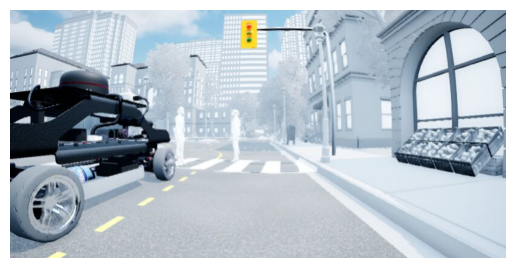

In [8]:
## display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(df_images.loc[df_images["id"]==80, "img_front"].values[0])
imgplot = plt.imshow(img)
plt.axis('off') # no axes for this plot
plt.show()

In [9]:
sc_01 = pd.read_csv(r"lidar/lidar_data_49.csv")
sc_02 = pd.read_csv(r"lidar/lidar_data_99.csv")
sc_03 = pd.read_csv(r"lidar/lidar_data_149.csv")
df_lidar = pd.concat([sc_01, sc_02,sc_03], ignore_index=True)
df_lidar.head()

,id,angle,distance
0,0,0.000000,0.0
1,0,0.000126,0.0
2,0,0.000251,0.0
3,0,0.000377,0.0
4,0,0.000503,0.0


In [10]:
dataset_lidar = pd.merge(df_lidar, df_images, on="id", how="left")
dataset_lidar.head()

,id,angle,distance,img_front
0,0,0.000000,0.0,images/front/image_0_.png
1,0,0.000126,0.0,images/front/image_0_.png
2,0,0.000251,0.0,images/front/image_0_.png
3,0,0.000377,0.0,images/front/image_0_.png
4,0,0.000503,0.0,images/front/image_0_.png


In [ ]:

angles_deg = dataset_lidar["angle"]
distances = dataset_lidar["distance"]


front_mask = (angles_deg <= 4*np.pi/9) | (angles_deg >= 2*np.pi - 4*np.pi/9)

filtered_angles = angles_deg[front_mask]
filtered_distances = distances[front_mask]

In [18]:
filtered_distances

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
7499995    4.270566
7499996    4.270714
7499997    4.270862
7499998    4.271010
7499999    4.271158
Name: distance, Length: 3333450, dtype: float64

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
K_CLUSTERS = 10  # Número de clústeres a encontrar en cada frame


centroids_result = {
        "ids": [],
        "distances": [],
        "angles": [],
        "img_front": []
    }

df_final_lidar_centroindes = pd.DataFrame()
for ids in range(0,149):

    ssc_sample = dataset_lidar.loc[dataset_lidar["id"]== ids]
    
    angles_deg =  ssc_sample["angle"]
    distances  =  ssc_sample["distance"]
    
    #filtro final para el campo de vision de la camara delantera del vehiculo
    front_mask = (angles_deg <= 4*np.pi/9) | (angles_deg >= 2*np.pi - 4*np.pi/9)

    filtered_angles = angles_deg[front_mask]
    filtered_distances = distances[front_mask]
    
    
    x = filtered_distances * np.sin(filtered_angles)
    y = filtered_distances * np.cos(filtered_angles)

    # Apilar los puntos para el modelo K-Means
    X = np.column_stack([x, y])

    centroids = {}

    # Asegurarse de que hay puntos para procesar

    try:
        kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init='auto')
        kmeans.fit(X)
    except Exception as e:
        continue

    # Guardar solo los centroides en el diccionario
    
    
    centroid_sequences = kmeans.cluster_centers_

    centroids_result["distances"] = centroid_sequences[:, 0]
    
    centroids_result["angles"] = centroid_sequences[:, 1]
    
    centroids_result["ids"] = [ids] * K_CLUSTERS
    
    centroids_result["img_front"] = ssc_sample["img_front"].values[0]
    
    df_centroindes = pd.DataFrame(centroids_result)
    df_final_lidar_centroindes = pd.concat([df_final_lidar_centroindes, df_centroindes], ignore_index=True)
    
df_final_lidar_centroindes.head()


,ids,distances,angles,img_front
0,0,3.985577,3.273432,images/front/image_0_.png
1,0,-29.845528,57.360813,images/front/image_0_.png
2,0,-28.159211,13.968963,images/front/image_0_.png
3,0,4.380362,46.937649,images/front/image_0_.png
4,0,-48.192383,10.683062,images/front/image_0_.png


In [73]:
df_final_lidar_centroindes.loc[df_final_lidar_centroindes["ids"]==0]

,ids,distances,angles,img_front
0,0,3.985577,3.273432,images/front/image_0_.png
1,0,-29.845528,57.360813,images/front/image_0_.png
2,0,-28.159211,13.968963,images/front/image_0_.png
3,0,4.380362,46.937649,images/front/image_0_.png
4,0,-48.192383,10.683062,images/front/image_0_.png
5,0,-44.768617,50.094452,images/front/image_0_.png
6,0,4.234669,12.133595,images/front/image_0_.png
7,0,-11.917619,57.675892,images/front/image_0_.png
8,0,1.870668,29.525996,images/front/image_0_.png
9,0,-7.481466,6.131802,images/front/image_0_.png


In [87]:
## tRABAJAREMOS SOLO CON UNA ESCENA. DE LA IMAGEN 0 AL 5
escena = df_final_lidar_centroindes.loc[df_final_lidar_centroindes["ids"]<=5]
escena.head()

,ids,distances,angles,img_front
0,0,3.985577,3.273432,images/front/image_0_.png
1,0,-29.845528,57.360813,images/front/image_0_.png
2,0,-28.159211,13.968963,images/front/image_0_.png
3,0,4.380362,46.937649,images/front/image_0_.png
4,0,-48.192383,10.683062,images/front/image_0_.png


### lidar Data

Lidar data is 2 dimensional data

In [88]:
escena.shape

(60, 4)

# Agnostic Maskink with SAM

In [89]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/lfsolisnavarro/concordia_research/label_lidar_data


In [20]:
## Install Segment Anything Model (SAM) and other dependencies
#!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

In [21]:
#!mkdir -p {HOME}/weights
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [77]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/home/lfsolisnavarro/concordia_research/label_lidar_data/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [78]:
## Load Model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [79]:
DEVICE

device(type='cuda', index=0)

In [81]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/home/lfsolisnavarro/concordia_research/label_lidar_data/env/lib/python3.8/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sta

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [82]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [83]:
IMAGE_NAME = "images/front/image_80_.png"
IMAGE_PATH = os.path.join(HOME, IMAGE_NAME)

In [23]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

In [24]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


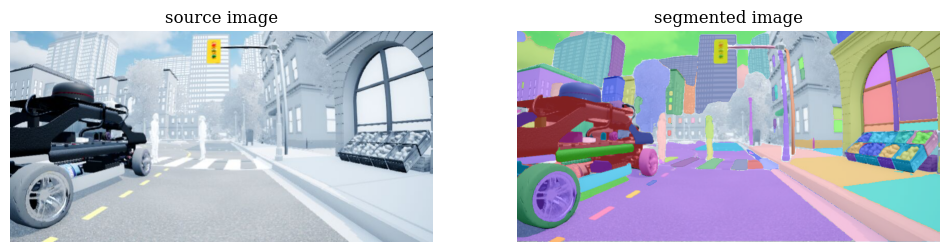

In [25]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [26]:
sam_result[2]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 12942,
 'bbox': [0, 257, 122, 125],
 'predicted_iou': 1.0183521509170532,
 'point_coords': [[38.4375, 262.65625]],
 'stability_score': 0.9933764338493347,
 'crop_box': [0, 0, 820, 410]}

In [27]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

type(masks)

list

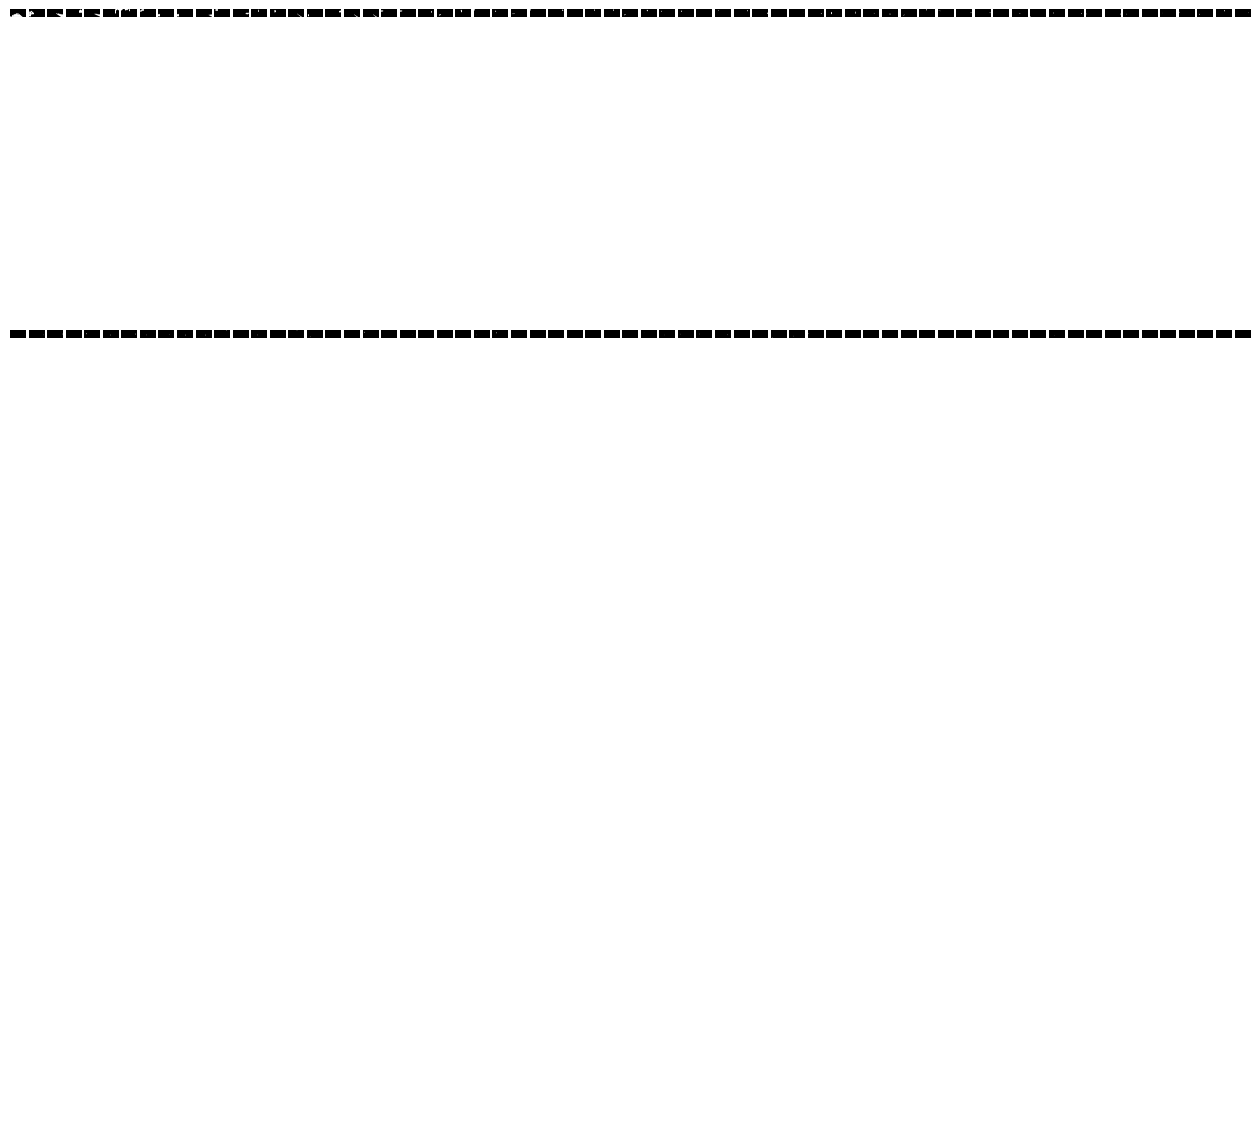

In [42]:

sv.plot_images_grid(
    images=masks,
    grid_size=(4, int(len(masks) / 2)),
    size=(16, 16)
)

## Create a caption of each region

In [92]:
# pip install torch torchvision pillow numpy transformers accelerate==0.33.0
from PIL import Image
import numpy as np
import torch
from torchvision.ops import masks_to_boxes
from transformers import AutoProcessor, Blip2ForConditionalGeneration

/home/lfsolisnavarro/concordia_research/label_lidar_data/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## configuracion del modelo
MODEL_NAME = "Salesforce/blip2-flan-t5-xl"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


processor = AutoProcessor.from_pretrained(MODEL_NAME)
model = Blip2ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32,
    low_cpu_mem_usage=True,
).to(DEVICE).eval() 

Loading checkpoint shards: 100%|██████████| 2/2 [19:52<00:00, 596.21s/it]


In [99]:
## create a folder for save masked regions
os.makedirs("masked_regions", exist_ok=True)

In [101]:
IMAGE_PATH

'/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png'

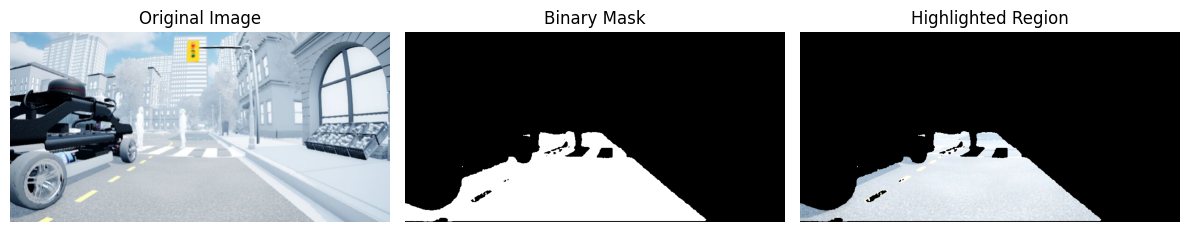

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_48076983.png', 'caption': 'a car driving down a road'}
Caption: a car driving down a road


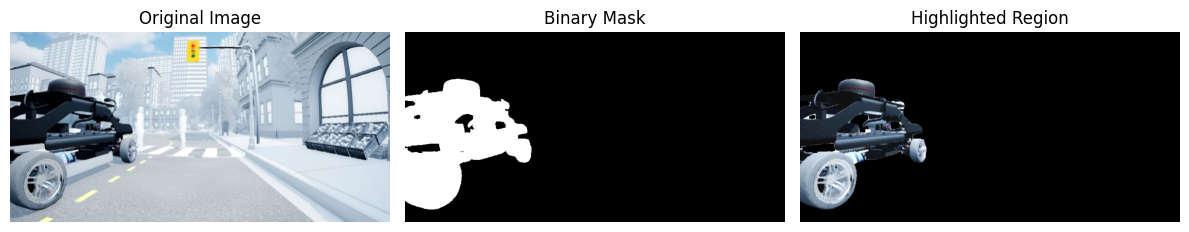

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_13607876.png', 'caption': 'a car with wheels'}
Caption: a car with wheels


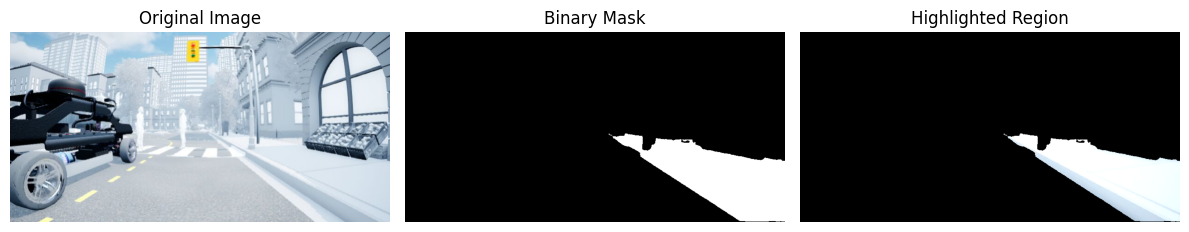

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_25476295.png', 'caption': 'a white car driving down a dark street'}
Caption: a white car driving down a dark street


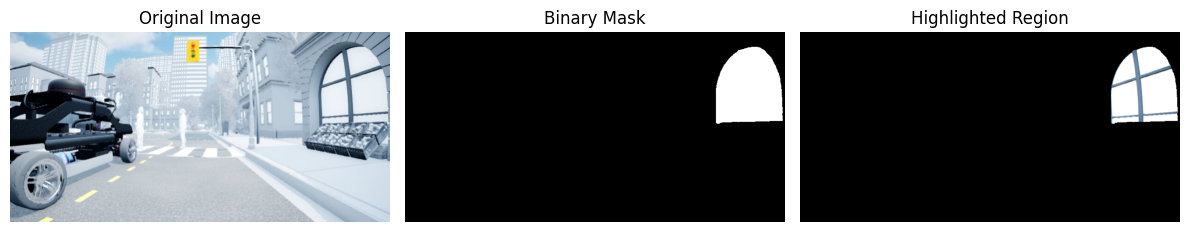

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_13957907.png', 'caption': 'a window'}
Caption: a window


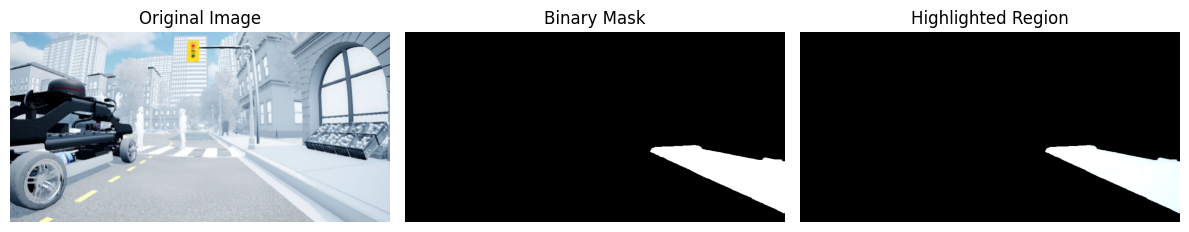

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_14561078.png', 'caption': 'a white car driving in a dark street'}
Caption: a white car driving in a dark street


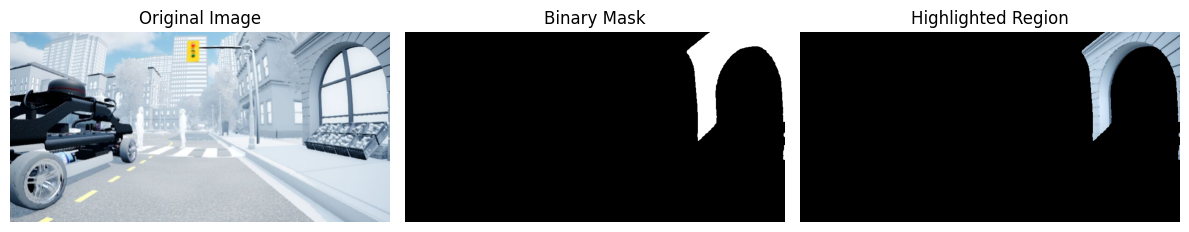

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_9961966.png', 'caption': 'a white archway'}
Caption: a white archway


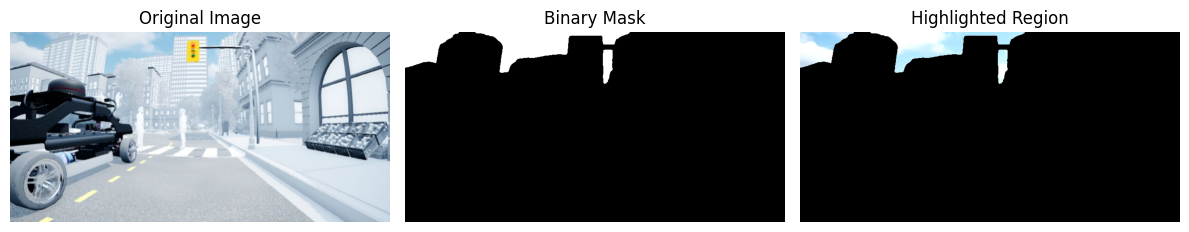

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_12372088.png', 'caption': 'a silhouette of a stonehenge'}
Caption: a silhouette of a stonehenge


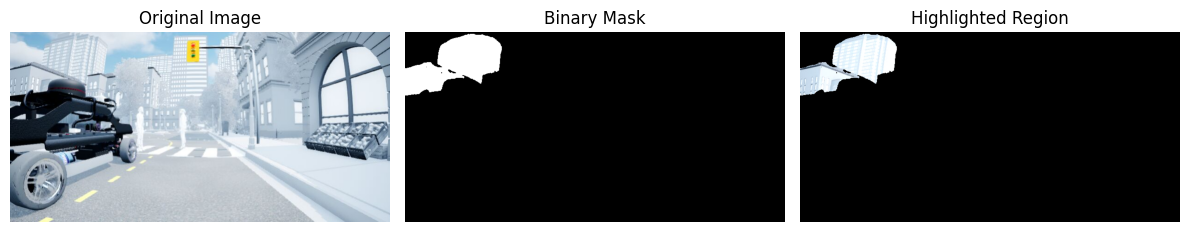

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_11331130.png', 'caption': 'a cityscape with buildings and a car'}
Caption: a cityscape with buildings and a car


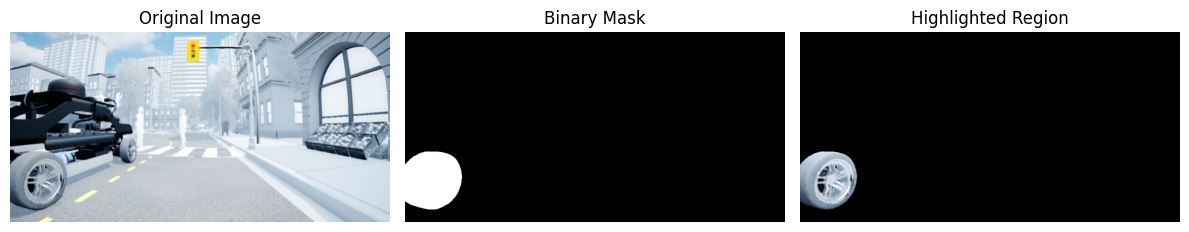

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_6644555.png', 'caption': 'a car driving on a dark background'}
Caption: a car driving on a dark background


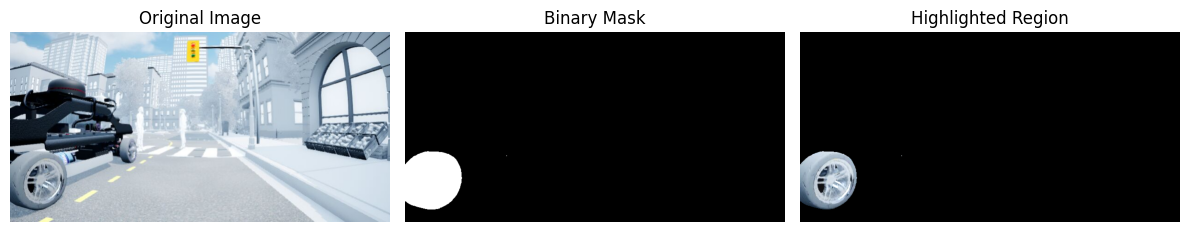

{'img': '/home/lfsolisnavarro/concordia_research/label_lidar_data/images/front/image_80_.png', 'region': 'masked_regions_80/image_80_/mask_6633838.png', 'caption': 'a car with a wheel'}
Caption: a car with a wheel


In [ ]:
# create a masking of each image

RGB_PATH = IMAGE_PATH     # <- tu imagen original
out_dir = f"masked_regions/{IMAGE_PATH.split('/')[-1][:-4]}"
os.makedirs(out_dir, exist_ok=True)  # crea la carpeta si no existe

PROMPT = """
          Consider a context of autonomous vehicles and urban environments.
          
          Question: what is the content of the image? Answer:
          
          """

masking_captions = pd.DataFrame(columns = ["img","region","caption"])


for mask in masks[0:10]:

  mask_bin = (mask > 100).astype(np.uint8)

  ## mascara en imagen
  mask_img = Image.fromarray(mask_bin * 255, mode="L")


  ## cargamos la imagen original
  reversedgb = Image.open(RGB_PATH).convert("RGB")

  #convertimos a array
  arr = np.array(reversedgb).astype(np.uint8)
  mask = np.array(mask) > 0  # True = zona blanca


  vis = arr.copy()
  # Atenuar fondo (zona negra en máscara)
  vis[~mask] = (0* vis[~mask]).astype(np.uint8)  # más oscuro

  # Resaltar la región blanca (más clara/brillante)
  vis[mask] = np.clip(vis[mask] * 1.1 + 15 , 0, 255).astype(np.uint8)

  vis_img_2 = Image.fromarray((vis.astype(np.uint8)))
  vis_img_2.save(os.path.join(out_dir, f"mask_{vis.sum()}.png"))

  # Mostrar resultados
  plt.figure(figsize=(12,4))
  plt.subplot(1,3,1); plt.imshow(arr); plt.title("Original Image"); plt.axis("off")
  plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Binary Mask"); plt.axis("off")
  plt.subplot(1,3,3); plt.imshow(vis); plt.title("Highlighted Region"); plt.axis("off")
  plt.tight_layout()
  plt.show()


  with torch.inference_mode():
      inputs = processor(images=vis, text=PROMPT, return_tensors="pt").to(DEVICE, dtype=model.dtype)
      out = model.generate(**inputs, max_new_tokens=40)
      caption = processor.decode(out[0], skip_special_tokens=True).strip()
  data = {
      "img": IMAGE_PATH,
      "region": os.path.join(out_dir, f"mask_{vis.sum()}.png"),
      "caption": caption
  }
  print(data)
  masking_captions = pd.concat([masking_captions, pd.DataFrame(data,index=[0])])

  print("Caption:", caption)


In [67]:
masking_captions.head()

,img,region,caption
0,/home/lfsolisnavarro/concordia_research/label_...,masked_regions_80/image_80_/mask_48076983.png,a car driving down a road
0,/home/lfsolisnavarro/concordia_research/label_...,masked_regions_80/image_80_/mask_13607876.png,a car with wheels
0,/home/lfsolisnavarro/concordia_research/label_...,masked_regions_80/image_80_/mask_25476295.png,a white car driving down a dark street
0,/home/lfsolisnavarro/concordia_research/label_...,masked_regions_80/image_80_/mask_13957907.png,a window
0,/home/lfsolisnavarro/concordia_research/label_...,masked_regions_80/image_80_/mask_14561078.png,a white car driving in a dark street


In [68]:
masking_captions.to_csv("masking_captions_80.csv", index=False)

### Crear una descripcion en lenguage natural de esos maskings

In [90]:
escena.head()

,ids,distances,angles,img_front
0,0,3.985577,3.273432,images/front/image_0_.png
1,0,-29.845528,57.360813,images/front/image_0_.png
2,0,-28.159211,13.968963,images/front/image_0_.png
3,0,4.380362,46.937649,images/front/image_0_.png
4,0,-48.192383,10.683062,images/front/image_0_.png


In [104]:
import cv2
import os
## Perspectivas
HOME = os.getcwd()
IMAGES_FOLDER = "images"
MASKED_FOLDER = "masked_regions"
persp = [
    "front",
]
cantidad_imagenes = 5
i=0
df_prompt = pd.DataFrame(columns=["img","region","caption"])

for p in persp:
    for i in range(0,cantidad_imagenes):
        images = os.listdir(os.path.join(HOME, IMAGES_FOLDER, p))
        path_image = os.path.join(HOME, IMAGES_FOLDER, p, f"image_{i}_.png")
        
        ## GET MASKS WITH SAM
        image_bgr = cv2.imread(path_image)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        sam_result = mask_generator.generate(image_rgb)
        
        masks = [
            mask['segmentation']
            for mask
            in sorted(sam_result, key=lambda x: x['area'], reverse=True)
        ]
        

        PROMPT = """
                What is the object in the image?: answer:
                """

        masking_captions = pd.DataFrame(columns = ["img","region","caption"])

        os.makedirs(os.path.join(HOME,MASKED_FOLDER,p,str(i)), exist_ok=True)  # crea la carpeta si no existe
        for mask in masks[0:5]:
            

            mask_bin = (mask > 100).astype(np.uint8)

            ## mascara en imagen
            mask_img = Image.fromarray(mask_bin * 255, mode="L")


            ## cargamos la imagen original
            reversedgb = Image.open(path_image).convert("RGB")

            #convertimos a array
            arr = np.array(reversedgb).astype(np.uint8)
            mask = np.array(mask) > 0  # True = zona blanca


            vis = arr.copy()
            # Atenuar fondo (zona negra en máscara)
            vis[~mask] = (0* vis[~mask]).astype(np.uint8)  # más oscuro

            # Resaltar la región blanca (más clara/brillante)
            vis[mask] = np.clip(vis[mask] * 1.1 + 15 , 0, 255).astype(np.uint8)

            vis_img_2 = Image.fromarray((vis.astype(np.uint8)))
            
            
            vis_img_2.save(os.path.join(HOME,MASKED_FOLDER,p,str(i), f"mask_{vis.sum()}.png"))


            with torch.inference_mode():
                inputs = processor(images=vis, text=PROMPT, return_tensors="pt").to(DEVICE, dtype=model.dtype)
                out = model.generate(**inputs, max_new_tokens=40)
                caption = processor.decode(out[0], skip_special_tokens=True).strip()
            data = {
                "img": path_image,
                "region": os.path.join(HOME,MASKED_FOLDER,p,str(i), f"mask_{vis.sum()}.png"),
                "caption": caption
            }
            masking_captions = pd.concat([masking_captions, pd.DataFrame(data,index=[0])])

            print("Caption:", caption)
                
            df_prompt = pd.concat([df_prompt, masking_captions], ignore_index=True)
                
            print(df_prompt)
            ## GET PROMPT OF EACH MARKED REGION
            
            ## EMBEDDING OF EACH REGION + PROMPT
        i+=1


Caption: a road
                                                 img  \
0  /home/lfsolisnavarro/concordia_research/label_...   

                                              region caption  
0  /home/lfsolisnavarro/concordia_research/label_...  a road  
Caption: a building
                                                 img  \
0  /home/lfsolisnavarro/concordia_research/label_...   
1  /home/lfsolisnavarro/concordia_research/label_...   
2  /home/lfsolisnavarro/concordia_research/label_...   

                                              region     caption  
0  /home/lfsolisnavarro/concordia_research/label_...      a road  
1  /home/lfsolisnavarro/concordia_research/label_...      a road  
2  /home/lfsolisnavarro/concordia_research/label_...  a building  
Caption: a black and white png
                                                 img  \
0  /home/lfsolisnavarro/concordia_research/label_...   
1  /home/lfsolisnavarro/concordia_research/label_...   
2  /home/lfsolisnavarro/concordia

In [105]:
df_prompt.head()

,img,region,caption
0,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a road
1,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a road
2,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a building
3,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a road
4,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a building


In [107]:
df_prompt.to_csv("/home/lfsolisnavarro/concordia_research/label_lidar_data/masked_captions/masked_captions_scene.csv", index=False)

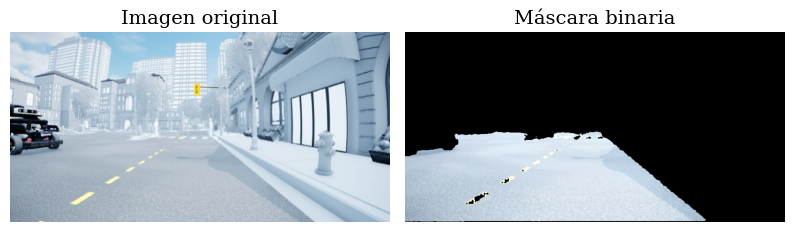

a road


In [106]:
## mostrar los resultados como imagenes

i=1

df_prompt_result = df_prompt.iloc[i]
img_rgb_result = Image.open(df_prompt_result["img"]).convert("RGB")
img_masked_result = Image.open(df_prompt_result["region"]).convert("RGB")
prompt_result = df_prompt_result["caption"]


# Mostrar resultados
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img_rgb_result); plt.title("Imagen original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(img_masked_result, cmap="gray"); plt.title("Máscara binaria"); plt.axis("off")
plt.tight_layout()
plt.show()

print(prompt_result)

# CREAR LAS PSEUDO-CLASES

In [108]:
## trabajaremos con una sola imagen

region_caption_imp = pd.read_csv("/home/lfsolisnavarro/concordia_research/label_lidar_data/masked_captions/masked_captions_scene.csv")
region_caption_imp.head()

,img,region,caption
0,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a road
1,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a road
2,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a building
3,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a road
4,/home/lfsolisnavarro/concordia_research/label_...,/home/lfsolisnavarro/concordia_research/label_...,a building


In [109]:
region_caption_imp["img"] = region_caption_imp["img"].str.replace("/home/lfsolisnavarro/concordia_research/label_lidar_data/","")
region_caption_imp["region"] = region_caption_imp["region"].str.replace("/home/lfsolisnavarro/concordia_research/label_lidar_data/","")
region_caption_imp.head()

,img,region,caption
0,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road
1,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road
2,images/front/image_0_.png,masked_regions/front/0/mask_42488650.png,a building
3,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road
4,images/front/image_0_.png,masked_regions/front/0/mask_42488650.png,a building


In [113]:
data_front_images = dataset_lidar[["id","angle","distance","img_front"]]
data_front_images.head()

,id,angle,distance,img_front
0,0,0.000000,0.0,images/front/image_0_.png
1,0,0.000126,0.0,images/front/image_0_.png
2,0,0.000251,0.0,images/front/image_0_.png
3,0,0.000377,0.0,images/front/image_0_.png
4,0,0.000503,0.0,images/front/image_0_.png


## Cargar los encoders de CLIP

In [28]:
#!pip install git+https://github.com/openai/CLIP.git
#!pip install clip
#!pip install scikit-image

In [114]:
import torch
import clip
from PIL import Image
import os
import numpy as np
import torch.nn.functional as F

class UnifiedCLIPEncoder:
    """
    Clase unificada para codificar textos y extraer mapas de características de imágenes
    usando el modelo CLIP.
    """
    def __init__(self, model_name="ViT-B/32"):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(model_name, device=self.device)
        print(f"Modelo CLIP cargado en el dispositivo: {self.device}")

        # Atributos para el hook
        self.hook_handle = None
        self.features = None

    def _hook_fn(self, module, input, output):
        """Hook para capturar las características de la capa intermedia."""
        self.features = output

    def _process_and_upsample_features(self, features_tensor, target_size=(224, 224)):
        """Procesa las características crudas del hook y las reescala."""
        # Cambiamos orden a [N, L, D]
        features_tensor = features_tensor.permute(1, 0, 2)
        # Quitamos el token [CLASS]
        patch_features = features_tensor[:, 1:, :]
        # Calculamos tamaño de la grilla (ej. 7 para ViT-B/32)
        grid_size = int(np.sqrt(patch_features.shape[1]))
        # Reorganizamos en una grilla 2D [N, H, W, D]
        feature_map = patch_features.reshape(1, grid_size, grid_size, -1)

        # --- Upsampling ---
        # Cambiamos orden a [N, D, H, W] para la función de interpolación
        feature_map_for_upsample = feature_map.permute(0, 3, 1, 2)
        upsampled_features = F.interpolate(
            feature_map_for_upsample,
            size=target_size,
            mode='bilinear',
            align_corners=False
        )
        # Quitamos la dimensión de batch y volvemos a poner los canales al final [H, W, D]
        upsampled_features = upsampled_features.squeeze(0).permute(1, 2, 0)
        return upsampled_features

    def encode(self, input_data, is_text):
        """
        Función principal que codifica texto o extrae el mapa de características de una imagen.
        """
        if is_text:
            # --- Procesar Texto ---
            tokenized_text = clip.tokenize([input_data]).to(self.device)
            with torch.no_grad():
                text_features = self.model.encode_text(tokenized_text)
                text_features /= text_features.norm(dim=-1, keepdim=True)
            return text_features
        else:
            # --- Procesar Imagen para obtener el mapa de características ---
            try:
                image = Image.open(input_data).convert("RGB")
            except FileNotFoundError:
                print(f"Error: Imagen no encontrada en '{input_data}'")
                return None

            target_layer = self.model.visual.transformer.resblocks[-1]
            self.hook_handle = target_layer.register_forward_hook(self._hook_fn)

            preprocessed_image = self.preprocess(image).unsqueeze(0).to(self.device)
            with torch.no_grad():
                self.model.encode_image(preprocessed_image)

            self.hook_handle.remove()

            if self.features is not None:
                return self._process_and_upsample_features(self.features)
            else:
                return None



In [121]:
# 1. Instanciamos nuestro codificador unificado
text_image_encoder = UnifiedCLIPEncoder()


clases = ["road", "build", "car"]

embedding_clases = []
i= 0
for clase in clases:
  embedding_clase = text_image_encoder.encode(clase, is_text=True)
  dato = {
      "id":i,
      "clase": clase,
      "embedding": embedding_clase
  }
  embedding_clases.append(dato)
  i+=1

Modelo CLIP cargado en el dispositivo: cuda


In [122]:
region_caption_imp["caption_embedding"] = region_caption_imp["caption"].apply(lambda x: text_image_encoder.encode(x, is_text=True))
region_caption_imp.head()

,img,region,caption,caption_embedding,pred_class_id,pred_class,pred_score
0,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road,"[[tensor(-0.0164, device='cuda:0', dtype=torch...",5,road,0.972715
1,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road,"[[tensor(-0.0164, device='cuda:0', dtype=torch...",5,road,0.972715
2,images/front/image_0_.png,masked_regions/front/0/mask_42488650.png,a building,"[[tensor(0.0109, device='cuda:0', dtype=torch....",0,car,0.857251
3,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road,"[[tensor(-0.0164, device='cuda:0', dtype=torch...",5,road,0.972715
4,images/front/image_0_.png,masked_regions/front/0/mask_42488650.png,a building,"[[tensor(0.0109, device='cuda:0', dtype=torch....",0,car,0.857251


In [123]:
import numpy as np

# --- utilidades ---
def to_numpy(x):
    """Convierte un embedding a np.ndarray 1D."""
    # torch.Tensor
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    # lista de tensores/valores -> np.array
    if isinstance(x, (list, tuple)):
        # si viene como [tensor(...), tensor(...), ...]
        try:
            import torch
            if len(x) > 0 and isinstance(x[0], torch.Tensor):
                x = np.array([t.item() for t in x])
            else:
                x = np.array(x)
        except Exception:
            x = np.array(x)
    # si ya es np.ndarray, ok
    return np.asarray(x).reshape(-1)

def l2_normalize(mat, axis=1, eps=1e-12):
    """Normaliza por L2 fila a fila (axis=1) o vector."""
    mat = np.asarray(mat, dtype=np.float32)
    if mat.ndim == 1:
        n = np.linalg.norm(mat) + eps
        return mat / n
    n = np.linalg.norm(mat, axis=axis, keepdims=True) + eps
    return mat / n

# --- prepara matriz de embeddings de clases ---
class_ids   = [d["id"]    for d in embedding_clases]
class_names = [d["clase"] for d in embedding_clases]
class_vecs  = [to_numpy(d["embedding"]) for d in embedding_clases]
class_mat   = l2_normalize(np.stack(class_vecs, axis=0))   # [C, D]

# --- función para clasificar 1 embedding ---
def classify_one(emb_vec, top_k=1, score_threshold=None):
    v = l2_normalize(to_numpy(emb_vec))                    # [D]
    sims = class_mat @ v                                   # cosenos [C]
    order = np.argsort(-sims)                              # descendente
    if top_k == 1:
        best_idx = order[0]
        best_score = float(sims[best_idx])
        if (score_threshold is not None) and (best_score < score_threshold):
            return {
                "pred_class_id": None,
                "pred_class": None,
                "pred_score": best_score,
                "topk": []
            }
        return {
            "pred_class_id": int(class_ids[best_idx]),
            "pred_class": class_names[best_idx],
            "pred_score": best_score,
            "topk": [(class_names[i], float(sims[i])) for i in order[:min(3, len(order))]]
        }
    else:
        k = min(top_k, len(order))
        top = [(class_names[i], float(sims[i]), int(class_ids[i])) for i in order[:k]]
        if score_threshold is not None:
            top = [t for t in top if t[1] >= score_threshold]
        pred = top[0] if len(top) else (None, None, None)
        return {
            "pred_class_id": pred[2],
            "pred_class": pred[0],
            "pred_score": pred[1],
            "topk": [(n, s) for (n, s, _) in top]
        }

# --- aplica a todo el DataFrame de regiones ---
# añade columnas: pred_class, pred_score, pred_class_id y top3 (opcional)
assignments = region_caption_imp["caption_embedding"].apply(lambda v: classify_one(v, top_k=3))

region_caption_imp["pred_class_id"] = assignments.apply(lambda d: d["pred_class_id"])
region_caption_imp["pred_class"]    = assignments.apply(lambda d: d["pred_class"])
region_caption_imp["pred_score"]    = assignments.apply(lambda d: d["pred_score"])

region_caption_imp.head()

,img,region,caption,caption_embedding,pred_class_id,pred_class,pred_score
0,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road,"[[tensor(-0.0164, device='cuda:0', dtype=torch...",0,road,0.972715
1,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road,"[[tensor(-0.0164, device='cuda:0', dtype=torch...",0,road,0.972715
2,images/front/image_0_.png,masked_regions/front/0/mask_42488650.png,a building,"[[tensor(0.0109, device='cuda:0', dtype=torch....",1,build,0.895298
3,images/front/image_0_.png,masked_regions/front/0/mask_63127885.png,a road,"[[tensor(-0.0164, device='cuda:0', dtype=torch...",0,road,0.972715
4,images/front/image_0_.png,masked_regions/front/0/mask_42488650.png,a building,"[[tensor(0.0109, device='cuda:0', dtype=torch....",1,build,0.895298


In [141]:
imagenes_escena = region_caption_imp["img"].unique()
imagenes_escena

array(['images/front/image_0_.png', 'images/front/image_1_.png',
       'images/front/image_2_.png', 'images/front/image_3_.png',
       'images/front/image_4_.png'], dtype=object)

In [142]:
escena.head()

,ids,distances,angles,img_front
0,0,3.985577,3.273432,images/front/image_0_.png
1,0,-29.845528,57.360813,images/front/image_0_.png
2,0,-28.159211,13.968963,images/front/image_0_.png
3,0,4.380362,46.937649,images/front/image_0_.png
4,0,-48.192383,10.683062,images/front/image_0_.png


In [ ]:
### dataset

df_final_escena = pd.DataFrame(columns=["scene_id","image_file_path","lidar_id","regions"])

for img_sc in imagenes_escena:
    region_caption_imp_img = region_caption_imp.loc[region_caption_imp["img"]== img_sc]
    dataset_total = {
        "scene_id": img_sc.replace("images/front/image_","").replace("_.png",""),
        "image_file_path": img_sc,
        "lidar_id": img_sc.replace("images/front/image_","").replace("_.png",""),
        "regions": []
    }
    for index, row in region_caption_imp_img.iterrows():
    
        region_data = {
            "region_file_path": row["region"],
            "caption": row["caption"],
            "predicted_class": row["pred_class"],
            "predicted_score": row["pred_score"]
        }
        
        dataset_total["regions"].append(region_data)
    df_final_escena = pd.concat([df_final_escena, pd.DataFrame(dataset_total)], ignore_index=True)
df_final_escena.head()
    

,scene_id,image_file_path,lidar_id,regions
0,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
1,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
2,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
3,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
4,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...


In [134]:
df_final_escena.to_json("/home/lfsolisnavarro/concordia_research/label_lidar_data/lidar_image_region_dataset.json", orient="records", lines=True)

In [138]:
df_final_escena

,scene_id,image_file_path,lidar_id,regions
0,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
1,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
2,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
3,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
4,0,images/front/image_0_.png,0,{'region_file_path': 'masked_regions/front/0/m...
...,...,...,...,...
70,4,images/front/image_4_.png,4,{'region_file_path': 'masked_regions/front/4/m...
71,4,images/front/image_4_.png,4,{'region_file_path': 'masked_regions/front/4/m...
72,4,images/front/image_4_.png,4,{'region_file_path': 'masked_regions/front/4/m...
73,4,images/front/image_4_.png,4,{'region_file_path': 'masked_regions/front/4/m...


In [144]:
escena

,ids,distances,angles,img_front
0,0,3.985577,3.273432,images/front/image_0_.png
1,0,-29.845528,57.360813,images/front/image_0_.png
2,0,-28.159211,13.968963,images/front/image_0_.png
3,0,4.380362,46.937649,images/front/image_0_.png
4,0,-48.192383,10.683062,images/front/image_0_.png
5,0,-44.768617,50.094452,images/front/image_0_.png
6,0,4.234669,12.133595,images/front/image_0_.png
7,0,-11.917619,57.675892,images/front/image_0_.png
8,0,1.870668,29.525996,images/front/image_0_.png
9,0,-7.481466,6.131802,images/front/image_0_.png


In [145]:
import pandas as pd
import numpy as np
import cv2
import json
import os
from glob import glob
import shutil



# ---
# 2. PROCESO PRINCIPAL: GENERACIÓN DEL DATASET
# ---
def process_dataset():
    """
    Proyecta puntos LiDAR a imágenes y los asocia con máscaras de segmentación.
    """
    print("--- Iniciando procesamiento del dataset... ---")
    
    # --- 2.1 Cargar datos y calibración ---
    
    # Cargar el archivo CSV de LiDAR
    lidar_df = pd.read_csv('/home/lfsolisnavarro/concordia_research/label_lidar_data/data_demo/lidar_data.csv')
    

    scale_x = -30  # Píxeles por metro en U (horizontal)
    scale_y = -30  # Píxeles por metro en V (vertical)
    center_u = 400 # Pixel central (columna)
    center_v = 580 # Pixel inferior (fila)
    
    H = np.array([
        [scale_x, 0,       center_u],
        [0,       scale_y, center_v],
        [0,       0,       1]
    ], dtype=np.float32)
    print("ADVERTENCIA: Usando matriz de calibración (H) de simulación.")

    # --- 2.2 Encontrar y agrupar máscaras ---
    
    # Busca todos los archivos de máscaras de la imagen
    mask_files = glob('/home/lfsolisnavarro/concordia_research/label_lidar_data/masked_regions/front/0/*.png')
    
    # Agrupa las máscaras por el nombre de la imagen a la que pertenecen
    image_to_masks = {}
    for f in mask_files:
        basename = os.path.basename(f) # Ej: "image_0_mask_A_car.png"
        
        # Asume el formato: {nombre_img}_mask_{id_region}_{etiqueta}.png
        try:
            image_name = basename.split('_mask_')[0] + '_.png'
            image_key = f'images/front/{image_name}'
        except IndexError:
            print(f"Saltando archivo con nombre incorrecto: {f}")
            continue
            
        if image_key not in image_to_masks:
            image_to_masks[image_key] = []
        image_to_masks[image_key].append(f)

    # Aquí guardaremos la estructura final del dataset
    final_dataset = []

    # --- 2.3 Iterar sobre cada imagen y procesar sus puntos ---
    
    # Obtenemos la forma de la imagen de la primera máscara (asumimos que todas son iguales)
    temp_mask = cv2.imread(mask_files[0], cv2.IMREAD_GRAYSCALE)
    img_height, img_width = temp_mask.shape

    for img_path, mask_paths in image_to_masks.items():
        
        # 2.3.1. Filtrar puntos LiDAR para esta imagen
        img_lidar_df = lidar_df[lidar_df['img_front'] == img_path].copy()
        if img_lidar_df.empty:
            print(f"No se encontraron puntos LiDAR para {img_path}, saltando.")
            continue

        print(f"\n--- Procesando imagen: {img_path} ---")
        
        # 2.3.2. Convertir Coordenadas Polares a Cartesianas (x, y)
        # ADVERTENCIA: Asumimos que las distancias negativas son un error y usamos abs()
        distances = np.abs(img_lidar_df['distance'].values)
        angles_rad = np.deg2rad(img_lidar_df['angle'].values)
        
        x_coords = distances * np.cos(angles_rad)
        y_coords = distances * np.sin(angles_rad)
        
        # 2.3.3. Proyectar puntos (x,y) a píxeles (u,v)
        
        # Crear puntos homogéneos [x, y, 1]
        lidar_pts_xy1 = np.vstack((x_coords, y_coords, np.ones(len(x_coords)))).T
        
        # Aplicar la homografía: H * [x, y, 1]^T -> [u', v', w']^T
        projected_pts_homogeneous = (H @ lidar_pts_xy1.T).T
        
        # Convertir de [u', v', w'] a [u, v] dividiendo por w'
        w = projected_pts_homogeneous[:, 2].reshape(-1, 1)
        projected_pts_pixel = projected_pts_homogeneous[:, :2] / w
        projected_pts_pixel = projected_pts_pixel.astype(int) # Coordenadas de píxel
        
        # Almacenar datos de la escena
        scene_data = {
            "scene_id": os.path.basename(img_path).replace('.png', ''),
            "image_file_path": img_path,
            "lidar_file_path": "data_demo/lidar_data.csv", # O el archivo específico
            "regions": []
        }

        # 2.3.4. Asociar puntos con máscaras
        for mask_path in mask_paths:
            
            # Extraer info del nombre de la máscara
            mask_basename = os.path.basename(mask_path).replace('.png', '')
            parts = mask_basename.split('_')
            region_id = parts[2]
            semantic_label = parts[3]
            
            # Cargar la máscara
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
            lidar_cluster_indices = []
            
            # Iterar sobre cada punto LiDAR proyectado
            for i in range(len(projected_pts_pixel)):
                u, v = projected_pts_pixel[i] # u = col, v = fila
                original_id = img_lidar_df['id'].iloc[i]
                
                # Comprobar si el punto está DENTRO de los límites de la imagen
                if 0 <= u < img_width and 0 <= v < img_height:
                    
                    # Comprobar si el píxel (v, u) está en la máscara
                    if mask[v, u] > 0: # 0 = fondo, >0 = máscara
                        lidar_cluster_indices.append(int(original_id))
            
            # Guardar la información de la región
            scene_data["regions"].append({
                "region_id": region_id,
                "semantic_label_clean": semantic_label,
                "lidar_cluster_indices": lidar_cluster_indices
                # Aquí añadirías "text_description" de BLIP-2
            })
            
            print(f"  > Región {region_id} ({semantic_label}): Encontrados {len(lidar_cluster_indices)} puntos.")
            if len(lidar_cluster_indices) > 0:
                print(f"    IDs: {lidar_cluster_indices}")

        final_dataset.append(scene_data)

    # --- 2.4 Guardar el dataset final ---
    output_path = 'final_processed_dataset.json'
    with open(output_path, 'w') as f:
        json.dump(final_dataset, f, indent=2)

    print(f"\n--- ¡Procesamiento completado! Dataset guardado en: {output_path} ---")

# ---
# 3. EJECUCIÓN
# ---
if __name__ == "__main__":
    process_dataset()

--- Iniciando procesamiento del dataset... ---
ADVERTENCIA: Usando matriz de calibración (H) de simulación.
No se encontraron puntos LiDAR para images/front/mask_63127885.png_.png, saltando.
No se encontraron puntos LiDAR para images/front/mask_42488650.png_.png, saltando.
No se encontraron puntos LiDAR para images/front/mask_28962538.png_.png, saltando.
No se encontraron puntos LiDAR para images/front/mask_24111947.png_.png, saltando.
No se encontraron puntos LiDAR para images/front/mask_17357957.png_.png, saltando.

--- ¡Procesamiento completado! Dataset guardado en: final_processed_dataset.json ---


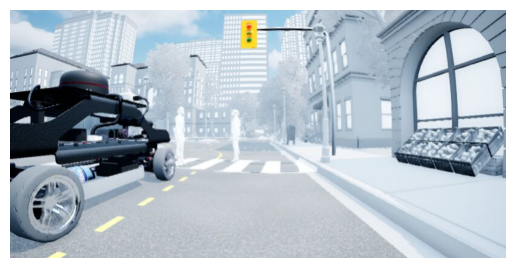

In [78]:
## display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(region_caption_imp.loc[region_caption_imp["img"]=="images/front/image_80_.png","img"].values[1])
imgplot = plt.imshow(img)
plt.axis('off') # no axes for this plot
plt.show()

In [79]:
import numpy as np
import cv2  # ó usa skimage.io.imread; abajo muestro con cv2
from skimage.morphology import binary_dilation, disk

# --- utils ---
def to_np(x):
    try:
        import torch
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x, dtype=np.float32).reshape(-1)

def l2n(v, eps=1e-12):
    v = np.asarray(v, dtype=np.float32)
    n = np.linalg.norm(v, axis=-1, keepdims=True) + eps
    return v / n

def cosine(a, b):
    return float(np.dot(a, b))

# --- carga máscaras binarias y normaliza embeddings ---
H, W = None, None  # se infiere de la 1ª máscara
masks = []         # lista de bool arrays [H,W]
embs  = []         # lista de vectores normalizados
classes = []       # clase por región
ids = []           # índice de fila

for idx, row in region_caption_imp.iterrows():
    # lee máscara; asumo 0 = fondo, >0 = segmento
    m = cv2.imread(row["region"], cv2.IMREAD_GRAYSCALE)
    if m is None:
        raise RuntimeError(f"No pude leer {row['region']}")
    m = m > 0
    if H is None:
        H, W = m.shape
    else:
        assert m.shape == (H, W), "Todas las máscaras deben tener mismo tamaño"

    masks.append(m)
    embs.append(to_np(row["caption_embedding"]))
    classes.append(row["pred_class"])
    ids.append(idx)

embs = l2n(np.stack(embs, 0))  # [N,D]

# --- construye adyacencias espaciales (se tocan si dilatadas se cruzan) ---
N = len(masks)
rad_px = 2  # radio de dilatación (ajusta p/ agrupar más/menos agresivo)
selem = disk(rad_px)

adj = [[] for _ in range(N)]  # lista de vecinos por nodo
for i in range(N):
    # dilata una sola vez para acelerar
    mi_d = binary_dilation(masks[i], selem)
    for j in range(i+1, N):
        # comparten borde si mi_d & masks[j] tiene algún píxel True
        touching = np.any(mi_d & masks[j])
        if touching:
            adj[i].append(j)
            adj[j].append(i)

# --- agrupa por clase y similitud de coseno ---
sim_thresh = 0.35  # AJUSTA según tu encoder (0.3–0.5 suele ir bien)
superseg_id = -np.ones(N, dtype=int)
current = 0

for c in sorted(set(classes)):
    # índices de regiones de esta clase
    idxs = [k for k in range(N) if classes[k] == c]
    idx_to_local = {k:i for i,k in enumerate(idxs)}

    # BFS/DFS sobre vecinos *de la misma clase* y sim ≥ umbral
    for k in idxs:
        if superseg_id[k] != -1:
            continue
        # inicia nuevo supersegmento
        queue = [k]
        superseg_id[k] = current
        while queue:
            u = queue.pop()
            for v in adj[u]:
                if classes[v] != c or superseg_id[v] != -1:
                    continue
                if cosine(embs[u], embs[v]) >= sim_thresh:
                    superseg_id[v] = current
                    queue.append(v)
        current += 1

# --- crea mapas de supersegmentos por clase y máscaras fusionadas ---
# (opcional) máscara por supersegmento (id -> máscara booleana)
super_masks = {}
for k, seg_id in enumerate(superseg_id):
    if seg_id not in super_masks:
        super_masks[seg_id] = np.zeros((H, W), dtype=bool)
    super_masks[seg_id] |= masks[k]

# DataFrame de salida con asignación
region_caption_imp["supersegment_id"] = [int(s) for s in superseg_id]

# (opcional) visualización sobre la imagen original
# pinta cada supersegmento con un color distinto con leve transparencia
img = cv2.imread("images/front/image_80_.png")[..., ::-1]  # RGB
overlay = img.copy()
for sid, m in super_masks.items():
    if sid < 0:
        continue
    color = np.random.randint(0, 255, (1,3), dtype=np.uint8)
    overlay[m] = (0.6*overlay[m] + 0.4*color).astype(np.uint8)

# guarda resultado si quieres
cv2.imwrite("supersegments_overlay.png", overlay[..., ::-1])  # BGR para cv2


True

In [80]:
import numpy as np
import cv2
import pandas as pd

# --- Paleta fija (RGB) y mapping clase->id (ajústalo a tus clases) ---
base_palette = {
    "wall": (139, 69, 19),      # Marrón
    "person": (255, 255, 0),    # Amarillo
    "car": (255, 20, 147),      # Rojo rosa (Fucsia/Rosa intenso)
    "tree": (34, 139, 34),      # Verde
    "sky": (135, 206, 235),     # Celeste
    "object": (128, 0, 128),    # Morado
}

# Si quieres que se genere automáticamente cualquier clase nueva:
def build_palette_and_ids(classes, base=base_palette):
    class2id = {c:i for i, c in enumerate(sorted(set(classes)))}
    palette = {}
    for c in class2id:
        if c in base:
            palette[c] = base[c]
        else:
            # color estable a partir del nombre
            rng = np.random.RandomState(abs(hash(c)) % (2**32))
            palette[c] = tuple(int(x) for x in rng.randint(0, 256, 3))
    return class2id, palette

# --- Construye label map (2D) seleccionando por mejor score en solapes ---
def build_label_map(df, background_id=255):
    # tamaño desde la 1ª máscara
    m0 = cv2.imread(df.iloc[0]["region"], cv2.IMREAD_GRAYSCALE)
    H, W = m0.shape
    label_map = np.full((H, W), background_id, np.int32)
    score_map = np.full((H, W), -np.inf, np.float32)

    class2id, palette = build_palette_and_ids(df["pred_class"].tolist())

    for _, row in df.iterrows():
        mask = cv2.imread(row["region"], cv2.IMREAD_GRAYSCALE) > 0
        cid  = class2id[row["pred_class"]]
        sc   = float(row["pred_score"]) if "pred_score" in row else 1.0

        # actualiza solo donde este segmento tiene mejor score
        upd = mask & (sc > score_map)
        label_map[upd] = cid
        score_map[upd] = sc

    return label_map, class2id, palette

label_map, class2id, palette = build_label_map(region_caption_imp)

# --- Imagen colorizada (RGB) por clase, útil para ver el resultado ---
max_id = max(class2id.values()) if len(class2id) else 0
lut = np.zeros((max(max_id+1, 256), 3), np.uint8)
for name, cid in class2id.items():
    lut[cid] = palette[name]
color_seg = lut[label_map]                       # (H,W,3) RGB
cv2.imwrite("seg_color.png", color_seg[..., ::-1])  # guarda en BGR

# (opcional) overlay sobre la imagen original
orig = cv2.imread("images/front/image_80_.png")[..., ::-1]  # RGB
overlay = (0.6*orig + 0.4*color_seg).astype(np.uint8)
cv2.imwrite("seg_overlay.png", overlay[..., ::-1])

# (opcional) guarda el label map crudo (índices de clase) como PNG de 16 bits si hay >255 clases
cv2.imwrite("seg_labels_uint16.png", label_map.astype(np.uint16))

# --- (opcional) tabla x, y, clase ---
inv_id2class = {v:k for k,v in class2id.items()}
ys, xs = np.where(label_map != 255)  # ignora fondo=255
df_xy = pd.DataFrame({
    "x": xs,
    "y": ys,
    "class_id": label_map[ys, xs],
    "class": [inv_id2class[i] for i in label_map[ys, xs]]
})
# df_xy.head()
# df_xy.to_parquet("xy_class.parquet")  # o .csv